In [4]:
import os
import numpy as np
import tensorflow as tf
import random 
from PIL import Image
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
#!pip install keras --upgrade

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Data stats

classes = list(sorted(os.listdir('/home/ubuntu/data/train')))

# Train/Test ratio
tr_ts = 6
print('Train to Test Ratio:',tr_ts)

for ele in classes:
  class_info = os.listdir('/home/ubuntu/data/train/' + ele)
  tr_len = tr_ts * len(class_info) // (tr_ts+1)
  ts_len = len(class_info) - tr_len
  print(ele,'Train Length is',tr_len,'  ', 'Test Length is',ts_len)


Train to Test Ratio: 6
c0 Train Length is 2133    Test Length is 356
c1 Train Length is 1943    Test Length is 324
c2 Train Length is 1986    Test Length is 331
c3 Train Length is 2010    Test Length is 336
c4 Train Length is 1993    Test Length is 333
c5 Train Length is 1981    Test Length is 331
c6 Train Length is 1992    Test Length is 333
c7 Train Length is 1716    Test Length is 286
c8 Train Length is 1638    Test Length is 273
c9 Train Length is 1824    Test Length is 305


In [7]:
# Creating partition of training and testing
partition = {'train': [], 
             'validation': []}

labels = {}
for ele in classes:
  class_pics = list(sorted(os.listdir('/home/ubuntu/data/train/' + ele)))
  tr_len = tr_ts * len(class_info) // (tr_ts+1)
  ts_len = len(class_info) - tr_len
   
  # appending id and labels for training 
  for imgs in class_pics[:tr_len]:
    partition['train'].append(ele + '/' + imgs)
    labels[ele + '/' + imgs] = ele[1:]

    
  
   # appending id and labels for testing
  for imgs in class_pics[tr_len:]:
    partition['validation'].append(ele + '/' + imgs)
    labels[ele + '/' + imgs] = ele[1:]

  
  # Check whether labels length match with partition vals

  assert len(partition['train']) + len(partition['validation']) == len(labels)




  

In [8]:
train_length = len(partition['train'])
test_length = len(partition['validation'])

print('Train to Test split is',train_length/test_length)

Train to Test split is 4.359464627151052


(480, 640, 3)


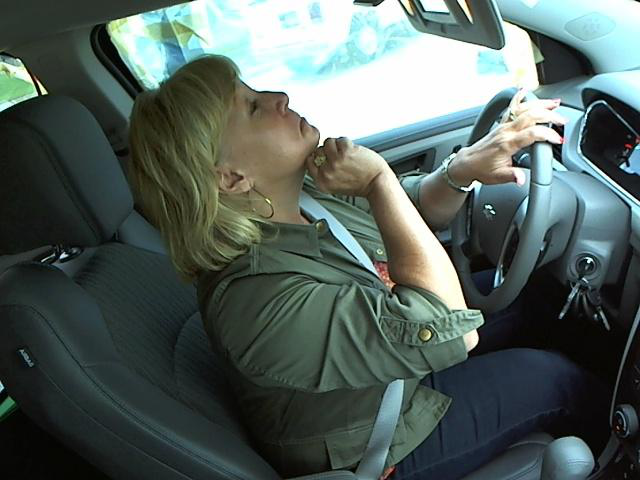

In [9]:
# Checking image pixel size and visualizing data
class_idx = str(random.randint(0,8))
img_idx = random.randint(0,10)

%matplotlib inline

imgs = os.listdir('/home/ubuntu/data/train/' + 'c' + class_idx)
img = imgs[img_idx]

#print(imgs)
im = Image.open('/home/ubuntu/data/train/' + 'c' + class_idx + '/' + img)
im_array = np.array(im)
print(im_array.shape)
im


In [10]:
import numpy as np

import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

# reference : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # X[i,] = np.load('data/' + ID + '.npy')

            X_img = Image.open('/home/ubuntu/data/train/' + ID )
            X_img = X_img.resize(size=(224,224))
            X[i,] = np.array(X_img)
            #print(i,ID)

            # Store class
            y[i] = self.labels[ID]

        return X, tensorflow.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [11]:
# # Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# # # Create a new model instance
# # model = create_model()

# # # Restore the weights
# #model.load_weights('./checkpoints/my_checkpoint')


In [12]:
# ref https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=R7W5plyZ-u9X


In [13]:
import tensorflow as tf
tf.test.is_gpu_available() # True/False

# Or only check for gpu's with cuda support
tf.test.is_gpu_available(cuda_only=True) 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [14]:
from tensorflow.keras.utils import multi_gpu_model

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.metrics
from tensorflow.keras.models import Sequential


# Parameters
params = {'dim': (224,224),
          'batch_size': 32,
          'n_classes': 10,
          'n_channels': 3,
          'shuffle': True}

# Datasets
# partition # IDs
# labels # Labels

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)


# Working on transfer learning
# ref: https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/
import tensorflow

# MobileNet V2
# base_model = tensorflow.keras.applications.MobileNetV2(input_shape = (224, 224, 3),
#                                                        include_top = False, 
#                                                        weights = "imagenet")

base_model = tensorflow.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


# freeze base
base_model.trainable = False



model = tf.keras.Sequential( [base_model,
                              tf.keras.layers.GlobalAveragePooling2D(),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Dense(10,activation="softmax")
                              ]
    
)

#model = multi_gpu_model(model,gpus=4)

base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['Accuracy',tf.keras.metrics.CategoricalAccuracy()])

# model.fit(x=training_generator, validation_data=validation_generator)
history = model.fit(x=training_generator,epochs = 100 , validation_data = validation_generator)

Epoch 1/100
570/570 [==============================] - 218s 382ms/step - loss: 10.8537 - accuracy: 7.6754e-05 - categorical_accuracy: 0.1026 - val_loss: 6.4671 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.1130
Epoch 2/100
570/570 [==============================] - 180s 316ms/step - loss: 8.6169 - accuracy: 1.0965e-05 - categorical_accuracy: 0.1048 - val_loss: 5.6360 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.1171
Epoch 3/100
570/570 [==============================] - 180s 316ms/step - loss: 8.1970 - accuracy: 5.4825e-06 - categorical_accuracy: 0.1085 - val_loss: 5.2975 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.1288
Epoch 4/100
570/570 [==============================] - 178s 312ms/step - loss: 7.8804 - accuracy: 5.4825e-06 - categorical_accuracy: 0.1152 - val_loss: 4.9623 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.1423
Epoch 5/100
570/570 [==============================] - 175s 307ms/step - loss: 7.6269 - accuracy: 5.4825e-06 - cate

In [ ]:
model.save('mbvn1_t1')

# New Section

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Old train version

In [ ]:

import numpy as np
import tensorflow as tf
import tensorflow.keras.metrics
from keras.models import Sequential


# Parameters
params = {'dim': (480,640),
          'batch_size': 32,
          'n_classes': 10,
          'n_channels': 3,
          'shuffle': True}

# Datasets
# partition # IDs
# labels # Labels

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# # Design model
model = Sequential()
# # Architecture

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3)  , activation='relu', input_shape=(480, 640, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['Accuracy',tf.keras.metrics.CategoricalAccuracy()])



# # visualize 
print(model.summary())

# # Train model on dataset
model.fit(x=training_generator, validation_data=validation_generator)
                    #use_multiprocessing=True,
                    #workers=6)



